![Class Relationship](../figs/classrelationship.png)

### 能量调度和变异、种子之间分别什么关系？

能量调度<span style="background:#ff4d4f">决定哪个种子被选中去变异</span>（相当于分配测试时间），变异器<span style="background:#fff88f">则负责对选中的种子进行修改以生成新的测试用例</span>。简单说：<span style="background:#d3f8b6">能量调度选种子，变异器改种子。</span>

#### 黑盒和灰盒的不同之处

区别：

选择种子：
黑盒中每个种子能量值=1，所以是均匀随机选择
灰盒根据各种策略（如覆盖率、基于频率、基于距离）的不同赋予不同能量值，指导选择

变异：

黑盒：不管输入的测试效果如何，继续随机变异
灰盒：记录并分析哪些输入触发了新路径，优先使用这些输入进行后续变异

In [1]:
n = 60000

In [2]:
# 我们的 AdvancedMutationFuzzer 类是 MutationFuzzer 类的高级和参数化版本，该类来自基于突变的模糊测试章节。它也继承自 Fuzzer 类。目前，我们只需要知道函数 fuzz()，它返回生成的输入，以及函数 runs()，它执行 fuzz() 指定次数。对于我们的 AdvancedMutationFuzzer 类，我们重写了函数 fuzz()。
from fuzzingbook.Fuzzer import Fuzzer
from typing import List, Set, Any, Tuple, Dict, Union
from fuzzingbook.GreyboxFuzzer import Seed, Mutator, PowerSchedule
import random
from fuzzingbook.Coverage import population_coverage

class AdvancedMutationFuzzer(Fuzzer):
    """Base class for mutation-based fuzzing."""

    def __init__(self, seeds: List[str],
                 mutator: Mutator,
                 schedule: PowerSchedule) -> None:
        """Constructor.
        `seeds` - a list of (input) strings to mutate.
        `mutator` - the mutator to apply.
        `schedule` - the power schedule to apply.
        """
        self.seeds = seeds
        self.mutator = mutator
        self.schedule = schedule
        self.inputs: List[str] = []
        self.reset()

    def reset(self) -> None:
        """Reset the initial population and seed index"""
        self.population = list(map(lambda x: Seed(x), self.seeds))
        self.seed_index = 0

    def create_candidate(self) -> str:
        """Returns an input generated by fuzzing a seed in the population"""
        seed = self.schedule.choose(self.population)

        # Stacking: Apply multiple mutations to generate the candidate
        candidate = seed.data
        trials = min(len(candidate), 1 << random.randint(1, 5))
        for i in range(trials):
            candidate = self.mutator.mutate(candidate)
        return candidate

    def fuzz(self) -> str:
        """Returns first each seed once and then generates new inputs"""
        if self.seed_index < len(self.seeds):
            # Still seeding
            self.inp = self.seeds[self.seed_index]
            self.seed_index += 1
        else:
            # Mutating
            self.inp = self.create_candidate()

        self.inputs.append(self.inp)
        return self.inp
    


seed_input = "ElonMusk"
mutation_fuzzer = AdvancedMutationFuzzer([seed_input], Mutator(), PowerSchedule())
print(mutation_fuzzer.fuzz())
print(mutation_fuzzer.fuzz())
print(mutation_fuzzer.fuzz())

ElonMusk
EloLuKsk
Mnu


In [3]:
def crashme(s: str) -> None:
    if len(s) > 0 and s[0] == 'b':
        if len(s) > 1 and s[1] == 'a':
            if len(s) > 2 and s[2] == 'd':
                if len(s) > 3 and s[3] == '!':
                    raise Exception()

让我们看看基于突变的黑盒模糊测试器在具有n = 30k个输入的测试活动中覆盖了多少个语句。

模糊测试器函数`runs(crashme_runner, trials=n)`生成`n`个输入，并通过`crashme_runner`在`crashme`函数上执行它们。如前所述，`crashme_runner`还收集覆盖率信息。

In [4]:
import time
from fuzzingbook.MutationFuzzer import FunctionCoverageRunner
# 默认的PowerSchedule,即把每个种子的能量（权重）都为1
blackbox_fuzzer = AdvancedMutationFuzzer([seed_input], Mutator(), PowerSchedule())
# n = 30000
start = time.time()
crashme_runner = FunctionCoverageRunner(crashme)
blackbox_fuzzer.runs(crashme_runner, trials=n)
# or
# blackbox_fuzzer.runs(FunctionCoverageRunner(crashme), trials=n)
end = time.time()

"It took the blackbox mutation-based fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the blackbox mutation-based fuzzer 12.47 seconds to generate and execute 60000 inputs.'

In [5]:
_, blackbox_coverage = population_coverage(blackbox_fuzzer.inputs, crashme)
bb_max_coverage = max(blackbox_coverage)

"The blackbox mutation-based fuzzer achieved a maximum coverage of %d statements." % bb_max_coverage


'The blackbox mutation-based fuzzer achieved a maximum coverage of 2 statements.'

In [6]:
blackbox_fuzzer.population

[ElonMusk]

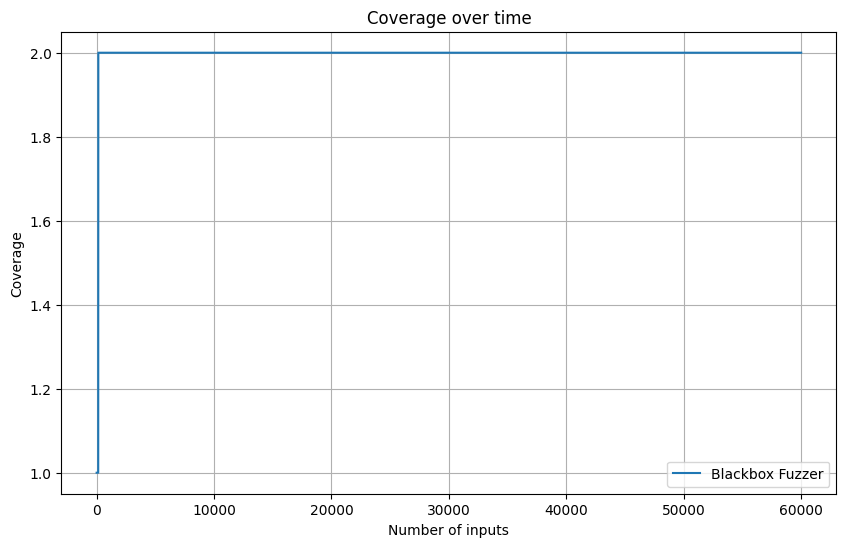

In [38]:
# # Plot coverage over time
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(blackbox_coverage)), blackbox_coverage, label="Blackbox Fuzzer")
plt.title("Coverage over time")
plt.xlabel("Number of inputs")
plt.ylabel("Coverage")
plt.grid()
plt.legend()
plt.show()

#### GreyboxFuzzer

核心区别：灰盒版本利用覆盖率信息指导测试，而黑盒版本完全靠随机变异。

#### reset() 初始化灰盒测试器的状态，清空覆盖路径历史和测试种群集合。

#### Run() function
run(runner)函数执行测试输入并跟踪其覆盖率：它使用来自父类的当前输入(self.inp，可能是初始种子或变异结果)执行测试，通过比对 new_coverage 和 self.coverages_seen 判断是否触及新路径，若发现新路径，则将当前输入封装为种子对象(包含输入数据和覆盖信息)，加入种群并记录其覆盖路径，这样该输入就能在后续测试中被选中进行变异。

run()函数继承自Fuzzer类的原因是，Fuzzer类提供了基本的模糊测试框架，包括生成和执行一个测试输入的功能。灰盒测试器主要扩展了该功能，在执行测试后增加了覆盖率分析和种子选择的机制。从代码中可以看到，通过super().run(runner)先执行父类的基本功能，然后添加覆盖率相关的处理逻辑。

In [8]:
class GreyboxFuzzer(AdvancedMutationFuzzer):
    """Coverage-guided mutational fuzzing."""
    # 初始化灰盒测试器的状态，清空覆盖路径历史和测试种群集合。
    def reset(self):
        """Reset the initial population, seed index, coverage information"""
        super().reset()
        self.coverages_seen = set()
        self.population = []  # population is filled during greybox fuzzing

    # run(runner)函数执行测试输入并跟踪其覆盖率：它使用来自父类的当前输入(self.inp，可能是初始种子或变异结果)执行测试，通过比对 new_coverage 和 self.coverages_seen 判断是否触及新路径，若发现新路径，则将当前输入封装为种子对象(包含输入数据和覆盖信息)，加入种群并记录其覆盖路径，这样该输入就能在后续测试中被选中进行变异。
    def run(self, runner: FunctionCoverageRunner) -> Tuple[Any, str]:
        """Run function(inp) while tracking coverage.
           If we reach new coverage,
           add inp to population and its coverage to population_coverage
        """
        result, outcome = super().run(runner)
        new_coverage = frozenset(runner.coverage())
        if new_coverage not in self.coverages_seen:
            # We have new coverage
            seed = Seed(self.inp)
            seed.coverage = runner.coverage()
            self.coverages_seen.add(new_coverage)
            self.population.append(seed)

        return (result, outcome)

In [9]:
seed_input = "good"
greybox_fuzzer = GreyboxFuzzer([seed_input], Mutator(), PowerSchedule())

start = time.time()
greybox_fuzzer.runs(FunctionCoverageRunner(crashme), trials=n)
end = time.time()

"It took the greybox mutation-based fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the greybox mutation-based fuzzer 12.48 seconds to generate and execute 60000 inputs.'

In [10]:
_, greybox_coverage = population_coverage(greybox_fuzzer.inputs, crashme)
gb_max_coverage = max(greybox_coverage)

"Our greybox mutation-based fuzzer covers %d more statements" % (gb_max_coverage - bb_max_coverage)

'Our greybox mutation-based fuzzer covers 3 more statements'

In [11]:
greybox_fuzzer.population

[good, bg\mo, baN\g, badNm\g, bad!jn\g, bad!,\dg]

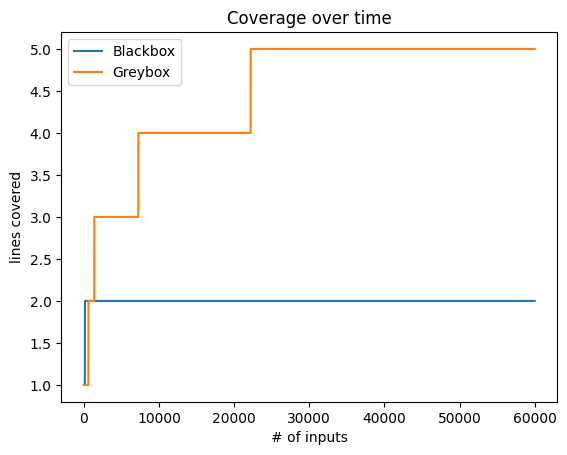

In [37]:
import matplotlib.pyplot as plt
line_bb, = plt.plot(blackbox_coverage, label="Blackbox")
line_gb, = plt.plot(greybox_coverage, label="Greybox")
plt.legend(handles=[line_bb, line_gb])
plt.title('Coverage over time')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

## Boosted Greybox Fuzzing

我们Boosted Greybox Fuzzing（改进的灰盒模糊测试器）会给那些有望实现更多覆盖率的种子分配更多能量。我们修改能量调度策略，使得执行"不寻常"路径的种子获得更多能量。这里的"不寻常路径"指的是那些很少被生成的输入所执行到的路径。

重点内容总结：

Boosted Greybox Fuzzing 的核心思想：
- 为"不常见路径"的种子分配更多能量(energy)
- 通过路径频率来判断路径的罕见程度
- 使用指数型能量调度(exponential power schedule)来分配能量
关键概念：
- Path ID: 使用 MD5 哈希来唯一标识一个覆盖路径
- 能量计算公式: $e(s) = \frac{1}{f(p(s))^a}$

        f(p): 路径被执行的频率
        a: 指数参数
        s: 种子输入
主要改进：
- 跟踪每个路径被执行的频率
- 基于路径频率动态调整种子的能量分配
- 低频路径获得更多测试机会



为了识别输入执行了哪条路径，我们利用了路径覆盖率章节中的getPathID函数。

In [16]:
import pickle   # 通过从对象中的所有信息生成字节数组来序列化对象
import hashlib  # 从字节数组生成128位哈希值

from typing import List, Set, Any, Tuple, Dict, Union, Sequence
from fuzzingbook.Fuzzer import Fuzzer
import random
import time
import matplotlib.pyplot as plt
from fuzzingbook.Coverage import population_coverage

In [17]:
# The function getPathID returns a unique hash for a coverage set.
# getPathID 函数通过将覆盖集排序后序列化，并生成其 MD5 哈希值，返回一个唯一的字符串标识。具体步骤是先对覆盖集排序，然后用 pickle 序列化，最后用 hashlib 计算 MD5 哈希。
# 详细解释
# 1. 输入：覆盖集：
# coverage 是一个集合（或列表），包含一组已被覆盖的语句或代码路径。例如，coverage = {10, 20, 30}。

# 2. 排序：
# sorted(coverage)：将覆盖集中的所有元素排序。排序的目的是确保即使覆盖集中的元素顺序不同，生成的哈希值也是相同的。例如，{10, 20, 30} 和 {20, 10, 30} 排序后都是 [10, 20, 30]。

# 3. 序列化：
# pickle.dumps(sorted_coverage)：将排序后的覆盖集序列化为一个字节串。pickle 模块将 Python 对象转换为字节流，以便可以对其进行哈希计算。例如，[10, 20, 30] 被序列化为一个特定的字节串。

# 4. 生成哈希值：
# hashlib.md5(pickled).hexdigest()：使用 hashlib 模块中的 md5 函数生成一个 MD5 哈希值，并将其转换为一个 32 位的十六进制字符串。这个字符串是整个覆盖集的唯一标识。

def getPathID(coverage: Any) -> str:
    """Returns a unique hash for the covered statements"""
    pickled = pickle.dumps(sorted(coverage))
    return hashlib.md5(pickled).hexdigest()

有几种方法可以基于路径的不常见程度来分配能量。在这种情况下，我们实现了一个指数能量调度，它按照以下方式计算种子 s 的能量 e(s)：

$e(s) = \frac{1}{f(p(s))^a}$

其中：

p(s) 返回种子 s 执行的路径ID

f(p) 返回路径 p 被生成的输入执行的次数

a 是给定的指数

假设在执行了1000次测试后，我们得到以下路径执行频率：

路径1 (b***): 执行了500次

路径2 (ba**): 执行了300次

路径3 (bad*): 执行了150次

路径4 (bad!): 执行了50次

如果我们设定指数 a = 2，那么每个路径对应种子的能量计算为：

```
# 路径1的种子能量
e(s1) = 1 / (500^2) = 1/250000 = 0.000004

# 路径2的种子能量
e(s2) = 1 / (300^2) = 1/90000 ≈ 0.000011

# 路径3的种子能量
e(s3) = 1 / (150^2) = 1/22500 ≈ 0.000044

# 路径4的种子能量
e(s4) = 1 / (50^2) = 1/2500 = 0.0004
```
从计算结果可以看出：

- 执行频率越低的路径（如路径4 "bad!"），其对应种子获得的能量越高

- 路径4的种子能量是路径1的100倍，这意味着在后续测试中，它被选中的概率会大大增加

- 这种分配方式可以帮助模糊测试器更多地探索那些不常见的路径，提高测试的覆盖率

- 这就是为什么这种能量分配策略能够提高模糊测试的效率，因为它会优先测试那些较少被执行到的代码路径。

In [18]:
class AFLFastSchedule(PowerSchedule):
    """Exponential power schedule as implemented in AFL"""

    def __init__(self, exponent: float) -> None:
        self.exponent = exponent

    def assignEnergy(self, population: Sequence[Seed]) -> None:
        """Assign exponential energy inversely proportional to path frequency"""
        for seed in population:
            seed.energy = 1 / (self.path_frequency[getPathID(seed.coverage)] ** self.exponent)

在灰盒模糊测试器中，让我们跟踪记录每个路径 p 被执行的次数 f(p)，并据此更新能量调度策略。

工作流程：

- 每次执行测试用例时，都会调用run方法
-  通过runner.coverage()获取当前执行的覆盖信息
- 使用getPathID将覆盖信息转换为唯一的路径ID
- 在path_frequency字典中更新这个路径的执行次数：
    - 如果是首次遇到的路径，设置计数为1
    - 如果是已知路径，将计数加1


In [ ]:
class CountingGreyboxFuzzer(GreyboxFuzzer):
    """这个类继承自GreyboxFuzzer，专门用来跟踪记录每个路径被执行的次数。"""
    """Count how often individual paths are exercised."""

    def reset(self):
        """Reset path frequency"""
        """重置路径频率计数器"""
        super().reset() # 调用父类的重置方法
        self.schedule.path_frequency = {} # 初始化一个空字典来存储路径频率

    def run(self, runner: FunctionCoverageRunner) -> Tuple[Any, str]:
        """Inform scheduler about path frequency"""
        """更新调度器的路径频率信息"""

         # 执行测试用例
        result, outcome = super().run(runner)

        # 获取当前执行路径的ID
        path_id = getPathID(runner.coverage())

        # 更新路径执行频率
        if path_id not in self.schedule.path_frequency:
            # 如果是新路径，初始化计数为1
            self.schedule.path_frequency[path_id] = 1
        else:
            # 如果是已知路径，计数加1
            self.schedule.path_frequency[path_id] += 1

        return(result, outcome)

在我们的简单示例上运行改进后的灰盒模糊测试器 n = 10000 次。我们将指数能量调度的指数值 a 设置为 5。

In [20]:
n = 10000
seed_input = "good"

# 创建一个AFLFast调度器实例，指数值设为5
# 这个调度器会使用前面讨论的指数能量分配公式 e(s) = 1/(f(p(s))^5)
fast_schedule = AFLFastSchedule(5)
fast_fuzzer = CountingGreyboxFuzzer([seed_input], Mutator(), fast_schedule)
start = time.time()
fast_fuzzer.runs(FunctionCoverageRunner(crashme), trials=n)
end = time.time()

"It took the fuzzer w/ exponential schedule %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer w/ exponential schedule 2.46 seconds to generate and execute 10000 inputs.'

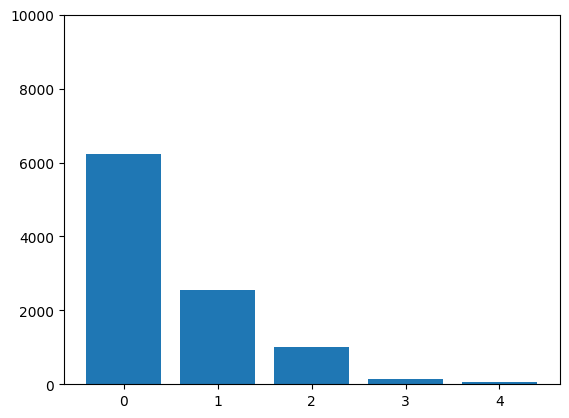

In [30]:
import numpy as np

x_axis = np.arange(len(fast_schedule.path_frequency))
y_axis = list(fast_schedule.path_frequency.values())

plt.bar(x_axis, y_axis)
plt.xticks(x_axis)
plt.ylim(0, n)
# plt.yscale("log")
# plt.yticks([10,100,1000,10000])
plt;

5个退出点：（即五个path）

- if len(s) > 0 and s[0] == 'b': 为false，跳出（如空字符串或非'b'开头）
- if len(s) > 1 and s[1] == 'a': 为false，跳出（如'b'或'bx'）
- if len(s) > 2 and s[2] == 'd': 为false，跳出（如'ba'或'bax'）
- if len(s) > 3 and s[3] == '!': 为false，跳出（如'bad'或'badx'）
- raise Exception(): 触发异常退出（输入为'bad!'）

In [32]:
print("path id 'p': path frequency 'f(p)'")
fast_schedule.path_frequency

path id 'p': path frequency 'f(p)'


{'6826122869ca182e5c98aeaec4bb1999': 6233,
 'cd6f029f8e9af042dc379fdd16230b4e': 2549,
 'f476979806dc02dbf506e74bc30dbe38': 1012,
 'd2cdf022cc9751774ab499fd43402836': 151,
 'dc0ad1576a037d9b970f2e68e064d978': 55}

它与采用传统powerschedule的灰盒模糊测试器相比如何？

In [33]:
seed_input = "good"
orig_schedule = PowerSchedule()
orig_fuzzer = CountingGreyboxFuzzer([seed_input], Mutator(), orig_schedule)
start = time.time()
orig_fuzzer.runs(FunctionCoverageRunner(crashme), trials=n)
end = time.time()

"It took the fuzzer w/ original schedule %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer w/ original schedule 2.30 seconds to generate and execute 10000 inputs.'

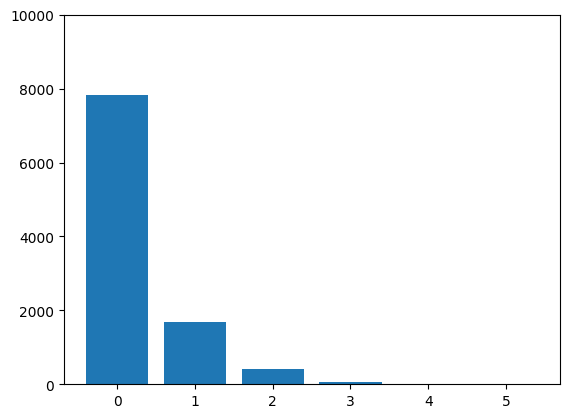

In [34]:
x_axis = np.arange(len(orig_schedule.path_frequency))
y_axis = list(orig_schedule.path_frequency.values())

plt.bar(x_axis, y_axis)
plt.xticks(x_axis)
plt.ylim(0, n)
# plt.yscale("log")
# plt.yticks([10,100,1000,10000])
plt;

In [35]:
print("path id 'p': path frequency 'f(p)'")
orig_schedule.path_frequency

path id 'p': path frequency 'f(p)'


{'6826122869ca182e5c98aeaec4bb1999': 7819,
 'cd6f029f8e9af042dc379fdd16230b4e': 1698,
 'f476979806dc02dbf506e74bc30dbe38': 400,
 'd2cdf022cc9751774ab499fd43402836': 70,
 'dc0ad1576a037d9b970f2e68e064d978': 12,
 '07b63c3a486fb6301746a9f7b25aee85': 1}

指数能量调度策略减少了"高频路径"的执行次数，并将这些执行机会分配给低频路径。使用传统能量调度时最少执行的路径，要么完全没有被执行到，要么执行频率明显更低。

让我们来看看分配给已发现种子的能量值。

In [27]:
#本来的能量分配
orig_energy = orig_schedule.normalizedEnergy(orig_fuzzer.population)

for (seed, norm_energy) in zip(orig_fuzzer.population, orig_energy):
    print("'%s', %0.5f, %s" % (getPathID(seed.coverage),
                               norm_energy, repr(seed.data)))

'6826122869ca182e5c98aeaec4bb1999', 0.20000, 'good'
'cd6f029f8e9af042dc379fdd16230b4e', 0.20000, 'bgO5od'
'f476979806dc02dbf506e74bc30dbe38', 0.20000, 'bag/5do'
'd2cdf022cc9751774ab499fd43402836', 0.20000, 'badeDnk'
'dc0ad1576a037d9b970f2e68e064d978', 0.20000, 'bad!\x1aDnc'


In [29]:
#指数能量调度策略的能量分配
fast_energy = fast_schedule.normalizedEnergy(fast_fuzzer.population)

for (seed, norm_energy) in zip(fast_fuzzer.population, fast_energy):
    print("'%s', %0.5f, %s" % (getPathID(seed.coverage),
                               norm_energy, repr(seed.data)))

'6826122869ca182e5c98aeaec4bb1999', 0.00000, 'good'
'cd6f029f8e9af042dc379fdd16230b4e', 0.00000, 'boe'
'f476979806dc02dbf506e74bc30dbe38', 0.00000, 'bax'
'd2cdf022cc9751774ab499fd43402836', 0.00637, 'bad'
'dc0ad1576a037d9b970f2e68e064d978', 0.99363, 'bad!'


新的指数能量调度策略为执行频率最低的路径的种子分配最多的能量。

让我们来比较一下在我们的简单示例中，两种方法随时间推移达到的覆盖率情况。

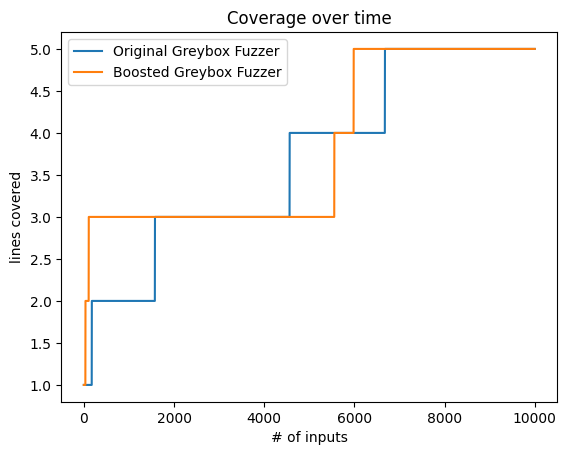

In [36]:
_, orig_coverage = population_coverage(orig_fuzzer.inputs, crashme)
_, fast_coverage = population_coverage(fast_fuzzer.inputs, crashme)
line_orig, = plt.plot(orig_coverage, label="Original Greybox Fuzzer")
line_fast, = plt.plot(fast_coverage, label="Boosted Greybox Fuzzer")
plt.legend(handles=[line_orig, line_fast])
plt.title('Coverage over time')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

正如预期的那样，改进后的灰盒模糊测试器（使用指数能量调度）能够更快地达到更高的覆盖率。

总结：通过更频繁地对低频路径的种子进行模糊测试，我们可以以更高效的方式探索程序路径。

实践建议：你可以尝试为快速能量调度使用其他指数值，或者完全改变能量调度策略。需要注意的是，过大的指数可能导致浮点数计算中的溢出和精度问题，从而产生意外的结果。